In [53]:
import pandas as pd 
import numpy as np 
from pandas import datetime 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF

from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt 
import seaborn as sns 

from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [43]:
# Holidays df
df = pd.read_csv('train.csv', parse_dates = True)

In [44]:
df = df[(df['Open'] != 0) & (df['Sales'] != 0)]
df['Sales'] = df['Sales'] * 1.0
df = df.sort_index(ascending = False)

sales_a = df[df.Store == 3].loc[:, ['Date','Sales']]
sales_b = df[df.Store == 262].loc[:, ['Date','Sales']]
sales_c = df[df.Store == 21].loc[:, ['Date','Sales']]
sales_d = df[df.Store == 15].loc[:, ['Date','Sales']]

sales_a['Date'] = pd.DatetimeIndex(sales_a['Date'])
sales_b['Date'] = pd.DatetimeIndex(sales_b['Date'])
sales_c['Date'] = pd.DatetimeIndex(sales_c['Date'])
sales_d['Date'] = pd.DatetimeIndex(sales_d['Date'])

sales_a = sales_a.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

sales_b = sales_b.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

sales_c = sales_c.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

sales_d = sales_d.rename(columns = {'Date': 'ds',
                          'Sales': 'y'})

# Prophet

- store 1, type C (not opened on Sundays)
- store 85, type B (opened on Sundays)

In [48]:
st_holidays = df[(df.StateHoliday == 'a') | 
                 (df.StateHoliday == 'b') & 
                 (df.StateHoliday == 'c')].loc[:, 'Date'].values
                                            
sch_holidays = df[df.SchoolHoliday == 1].loc[:, 'Date'].values

sth = pd.DataFrame({'ds': pd.to_datetime(st_holidays),
                    'holiday': 'state_holiday'
                    })

sch = pd.DataFrame({'ds': pd.to_datetime(sch_holidays),
                    'holiday': 'school_holiday'
                    })

hols = pd.concat((sth, sch))
hols.head()

,ds,holiday
0,2013-01-01,state_holiday
1,2013-01-01,state_holiday
2,2013-01-01,state_holiday
3,2013-01-01,state_holiday
4,2013-01-01,state_holiday


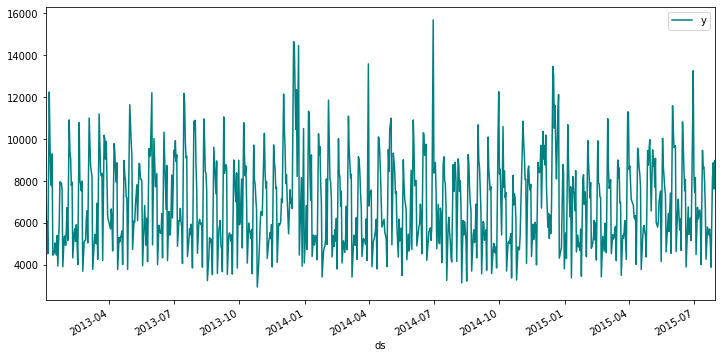

In [49]:
ax = sales_a.set_index('ds').plot(figsize = (12, 6),
                            color = 'teal')
plt.show()

In [50]:
# Type A
model_a = Prophet(interval_width = .95, holidays = hols)
model_a.fit(sales_a)

# Type B
model_b = Prophet(interval_width = .95, holidays = hols)
model_b.fit(sales_b)

# Type C
model_c = Prophet(interval_width = .95, holidays = hols)
model_c.fit(sales_c)

# Type D
model_d = Prophet(interval_width = .95, holidays = hols)
model_d.fit(sales_d)

# Forecasts
future_dates_a = model_a.make_future_dataframe(periods = 6*7) # 6 weeks
future_dates_b = model_b.make_future_dataframe(periods = 6*7) # 6 weeks
future_dates_c = model_c.make_future_dataframe(periods = 6*7) # 6 weeks
future_dates_d = model_d.make_future_dataframe(periods = 6*7) # 6 weeks

# Forecast type a
sales_a_forecasts = model_a.predict(future_dates_a)

# Forecast type b
sales_b_forecasts = model_b.predict(future_dates_b)

# Forecast type c
sales_c_forecasts = model_c.predict(future_dates_c)

# Forecast type d
sales_d_forecasts = model_d.predict(future_dates_d)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [56]:
sales_a_forecasts[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head()

fc_a = sales_a_forecasts[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

fc_b = sales_b_forecasts[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

fc_c = sales_c_forecasts[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

fc_d = sales_d_forecasts[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

Store 3 RMSPE: 0.10286215264776877
Store 262 RMSPE: 0.31825810242530683
Store 21 RMSPE: 0.46815415907310876
Store 15 RMSPE: 0.3385135315033396


<Figure size 360x1440 with 0 Axes>

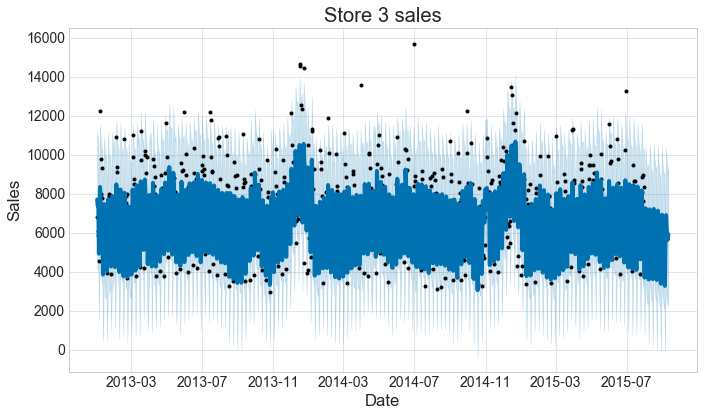

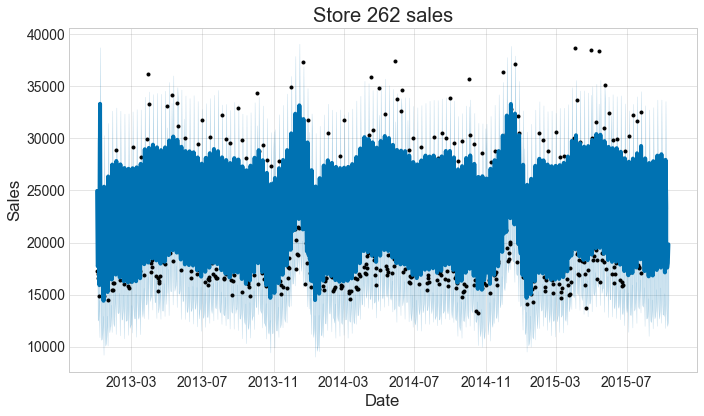

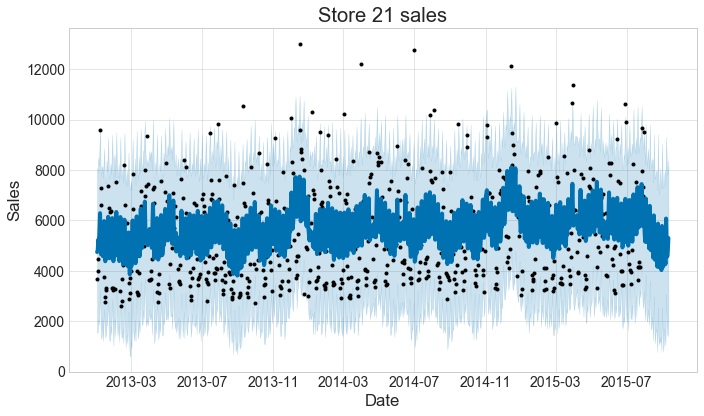

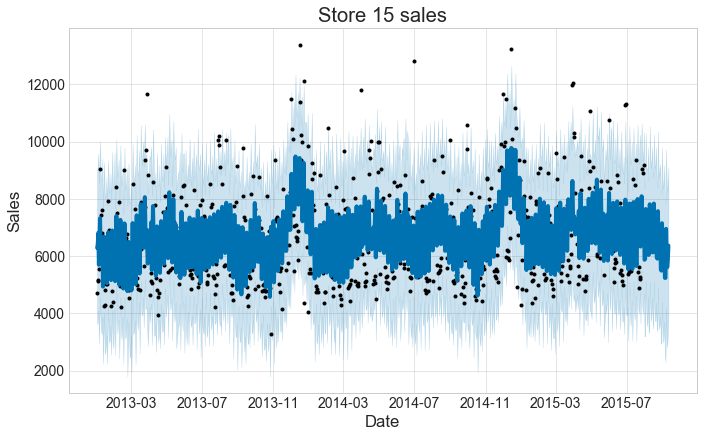

In [60]:
plt.figure(figsize = (5, 20))
plt.style.use(['fivethirtyeight', 'seaborn-whitegrid'])

# A 
model_a.plot(sales_a_forecasts, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 3 sales')
plt.tight_layout();

# A metrics 
metrics_a_df = sales_a_forecasts.set_index('ds')[['yhat']].join(sales_a.set_index('ds').y).reset_index()
metrics_a_df.dropna(inplace = True)

error_a = mean_squared_error(metrics_a_df.y, metrics_a_df.yhat)
#print('Store 3 RMSE: {}'.format(sqrt(error_a)))

# B
model_b.plot(sales_b_forecasts, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 262 sales')
plt.tight_layout(); 

# B metrics
metrics_b_df = sales_b_forecasts.set_index('ds')[['yhat']].join(sales_b.set_index('ds').y).reset_index()
metrics_b_df.dropna(inplace = True)

error_b = mean_squared_error(metrics_b_df.y, metrics_b_df.yhat)
#print('Store 262 RMSE: {}'.format(sqrt(error_b)))

# C
model_c.plot(sales_c_forecasts, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 21 sales')

plt.tight_layout(); 

# C metrics 
metrics_c_df = sales_c_forecasts.set_index('ds')[['yhat']].join(sales_c.set_index('ds').y).reset_index()
metrics_c_df.dropna(inplace = True)

error_c = mean_squared_error(metrics_c_df.y, metrics_c_df.yhat)
#print('Store 21 RMSE: {}'.format(sqrt(error_c)))

# D
model_d.plot(sales_d_forecasts, 
              xlabel = 'Date',
              ylabel = 'Sales')
plt.title('Store 15 sales')

# C metrics 
metrics_d_df = sales_d_forecasts.set_index('ds')[['yhat']].join(sales_d.set_index('ds').y).reset_index()
metrics_d_df.dropna(inplace = True)

error_d = mean_squared_error(metrics_d_df.y, metrics_d_df.yhat)
#print('Store 15 RMSE: {}'.format(sqrt(error_d)))

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

error_a = rmspe(sales_a['y'], fc_a['yhat'])
error_b = rmspe(sales_b['y'], fc_b['yhat'])
error_c = rmspe(sales_c['y'], fc_c['yhat'])
error_d = rmspe(sales_d['y'], fc_d['yhat'])

print('Store 3 RMSPE:', error_a)
print('Store 262 RMSPE:', error_b)
print('Store 21 RMSPE:', error_c)
print('Store 15 RMSPE:', error_d)

In [62]:
store_3 = ['store_3%s' % column for column in sales_a_forecasts.columns]
store_262 = ['store_262%s' % column for column in sales_b_forecasts.columns]
store_21 = ['store_21%s' % column for column in sales_c_forecasts.columns]
store_15 = ['store_15%s' % column for column in sales_d_forecasts.columns]

merge_a_forecast = sales_a_forecasts.copy()
merge_b_forecast = sales_b_forecasts.copy()
merge_c_forecast = sales_c_forecasts.copy()
merge_d_forecast = sales_d_forecasts.copy()

merge_a_forecast.columns = store_3
merge_b_forecast.columns = store_262
merge_c_forecast.columns = store_21
merge_d_forecast.columns = store_15

all_forecasts = pd.merge(merge_a_forecast, merge_b_forecast,
                        merge_c_forecast, merge_d_forecast,
                        how = 'inner', 
                        left_on = 'store_3ds',
                        right_on = 'store_15ds')

all_forecasts = all_forecasts.rename(columns = {'store_3ds': 'Date'}).drop('')

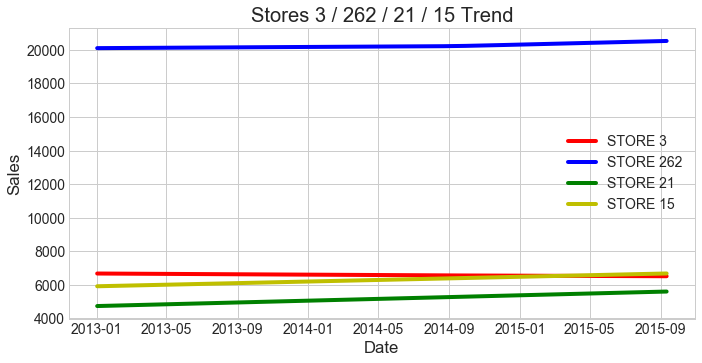

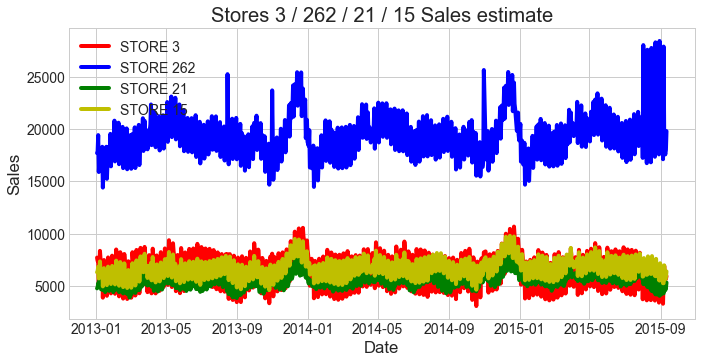

In [84]:
all_forecasts = pd.merge(merge_a_forecast, merge_b_forecast,
                        how = 'inner',
                        left_on = 'store_3ds',
                        right_on = 'store_262ds')

all_forecasts = all_forecasts.rename(columns = {'store_3ds': 'Date'}).drop('store_262ds',
                                                                          axis = 1)

# C
all_forecasts = pd.merge(all_forecasts, merge_c_forecast,
                        how = 'inner',
                        left_on = 'Date',
                        right_on = 'store_21ds')

all_forecasts = all_forecasts.drop('store_21ds',axis = 1)

# D
all_forecasts = pd.merge(all_forecasts, merge_d_forecast,
                        how = 'inner',
                        left_on = 'Date',
                        right_on = 'store_15ds')

all_forecasts = all_forecasts.drop('store_15ds',axis = 1)

plt.figure(figsize = (10, 5))
plt.plot(all_forecasts['Date'], all_forecasts['store_3trend'], 'r-', label = 'STORE 3')
plt.plot(all_forecasts['Date'], all_forecasts['store_262trend'], 'b-', label = 'STORE 262')
plt.plot(all_forecasts['Date'], all_forecasts['store_21trend'], 'g-', label = 'STORE 21')
plt.plot(all_forecasts['Date'], all_forecasts['store_15trend'], 'y-', label = 'STORE 15')

plt.xlabel('Date') ; plt.ylabel('Sales')
plt.title('Stores 3 / 262 / 21 / 15 Trend')
plt.legend()

plt.figure(figsize = (10, 5))
plt.plot(all_forecasts['Date'], all_forecasts['store_3yhat'], 'r-', label = 'STORE 3')
plt.plot(all_forecasts['Date'], all_forecasts['store_262yhat'], 'b-', label = 'STORE 262')
plt.plot(all_forecasts['Date'], all_forecasts['store_21yhat'], 'g-', label = 'STORE 21')
plt.plot(all_forecasts['Date'], all_forecasts['store_15yhat'], 'y-', label = 'STORE 15')

plt.xlabel('Date') ; plt.ylabel('Sales')
plt.title('Stores 3 / 262 / 21 / 15 Sales estimate')
plt.legend()

KeyboardInterrupt: 

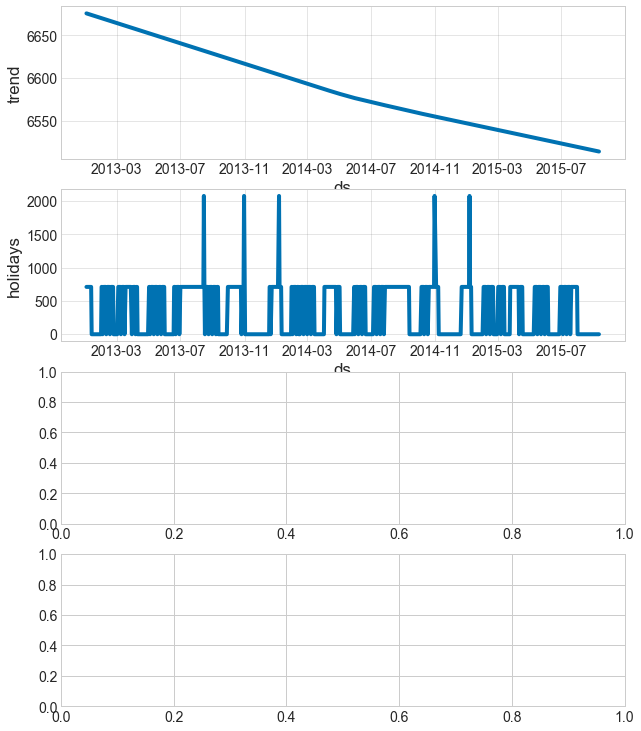

In [85]:
model_a.plot_components(sales_a_forecasts)

# XGB 

- All stores
- removing opened days with no sales 

In [141]:
fcs = forecasts2[['ds', 'yhat']].rename(columns = {'Date': 'ds', 
                                                  'Forecast': 'yhat'})     
fcs.head()

,ds,yhat
0,2013-01-02,5976.097169
1,2013-01-03,5919.597846
2,2013-01-04,6222.656682
3,2013-01-05,5065.347529
4,2013-01-07,7015.858072


Store 1 RMSE: 833.6548135402328
Store 85 RMSE: 2086.6041037506557
Store 1 RMSPE: 0.13549252682965585
Store 85 RMSPE: 0.12567833965138708


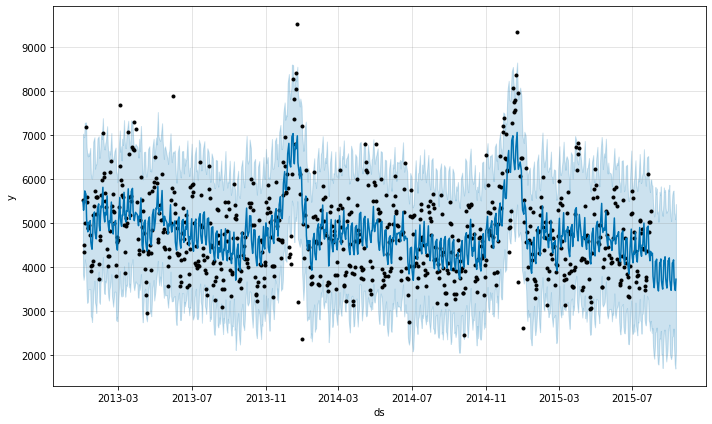

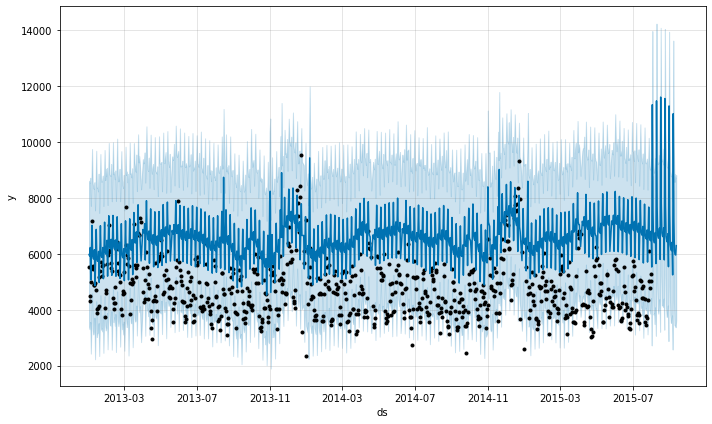

In [143]:
model.plot(forecasts);
model.plot(forecasts2);

from sklearn.metrics import mean_squared_error
from math import sqrt

metric_df = forecasts.set_index('ds')[['yhat']].join(sales_1.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)

metric_df2 = forecasts.set_index('ds')[['yhat']].join(sales_85.set_index('ds').y).reset_index()
metric_df2.dropna(inplace=True)

error = mean_squared_error(metric_df.y, metric_df.yhat)
error2 = mean_squared_error(metric_df2.y, metric_df2.yhat)

print('Store 1 RMSE: {}'. format(sqrt(error)))

print('Store 85 RMSE: {}'. format(sqrt(error2)))

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

error = rmspe(sales_1['y'], fcs['yhat'])
error2 = rmspe(sales_85['y'], fcs['yhat'])

print('Store 1 RMSPE:', error)
print('Store 85 RMSPE:', error2)

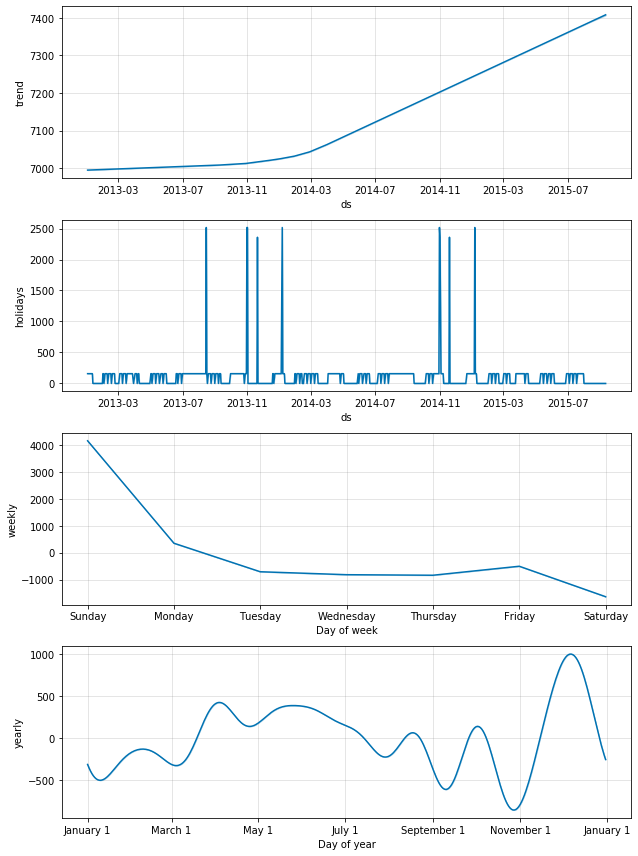

In [144]:
model2.plot_components(forecasts2);

In [31]:
test = pd.read_csv('test.csv', parse_dates = True, index_col = 'Date')
test.isnull().sum()

Id                0
Store             0
DayOfWeek         0
Open             11
Promo             0
StateHoliday      0
SchoolHoliday     0
dtype: int64

In [32]:
store = pd.read_csv('store.csv')
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [33]:
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),
                                    inplace = True)

store.fillna(0, inplace = True)

In [34]:
train = pd.read_csv('train.csv', parse_dates = True, index_col = 'Date')
train = train[(train['Open'] != 0) & (train['Sales'] != 0)]

train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['Sale/Customer'] = train['Sales']/train['Customers']
train['Sale/Customer'].describe()

df = pd.merge(train, store, 
              how = 'inner',
              on = 'Store')

df.shape

(844338, 22)

In [35]:
test[pd.isnull(test.Open)]

,Id,Store,DayOfWeek,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,
2015-09-17,480,622,4,NaN,1,0,0
2015-09-16,1336,622,3,NaN,1,0,0
2015-09-15,2192,622,2,NaN,1,0,0
2015-09-14,3048,622,1,NaN,1,0,0
2015-09-12,4760,622,6,NaN,0,0,0
2015-09-11,5616,622,5,NaN,0,0,0
2015-09-10,6472,622,4,NaN,0,0,0
2015-09-09,7328,622,3,NaN,0,0,0
2015-09-08,8184,622,2,NaN,0,0,0


In [36]:
# Should be open (Non-holidays)
test.fillna(1, inplace = True)

In [37]:
# data extraction
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear

# to numerical
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
test.StateHoliday.replace(mappings, inplace = True)

df.Assortment.replace(mappings, inplace = True)
df.StoreType.replace(mappings, inplace = True)
df.StateHoliday.replace(mappings, inplace = True)
df.drop('PromoInterval', axis = 1, inplace = True)

store.StoreType.replace(mappings, inplace = True)
store.Assortment.replace(mappings, inplace = True)
store.drop('PromoInterval', axis = 1, inplace = True)

test_store = pd.merge(test, store, 
                      how = 'inner', on = 'Store')

In [38]:
test_store['CompetitionOpen'] = 12*(test_store.Year - test_store.CompetitionOpenSinceYear) + (test_store.Month - test_store.CompetitionOpenSinceMonth)

test_store['PromoOpen'] = 12*(test_store.Year - test_store.Promo2SinceYear) + (test_store.WeekOfYear - test_store.Promo2SinceWeek) / 4.0

In [41]:
df['StateHoliday'] = df['StateHoliday'].apply(lambda x: float(x))
df['Assortment'] = df['Assortment'].apply(lambda x: float(x))

test_store['StateHoliday'] = test_store['StateHoliday'].apply(lambda x: float(x))
test_store['Assortment'] = test_store['Assortment'].apply(lambda x: float(x))

In [12]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor # wrapper

independents = [x for x in df.columns if x not in ['Customers', 
                                                            'Sales', 
                                                            'Sale/Customer']]
y = np.log(df.Sales) # log transformation of Sales
X = df

# split the data into train/test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, # 30% for the evaluation set
                                                    random_state = 42)

In [70]:
X.columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear',
       'Sale/Customer', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear'],
      dtype='object')

In [21]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat / y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y, yhat)

In [13]:
params = {
    'booster': 'gbtree', 
    'objective': 'reg:linear', # regression task
    'subsample': 0.8, # 80% of data to grow trees and prevent overfitting
    'colsample_bytree': 0.85, # 85% of features used
    'eta': 0.1, 
    'max_depth': 10, 
    'seed': 42} # for reproducible results

In [15]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train[independents], y_train)
dtest = xgb.DMatrix(X_test[independents], y_test)

watchlist = [(dtrain, 'train'), (dtest, 'test')]

# xgb_model = xgb.train(params, dtrain, 300, evals = watchlist,
                      #early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

In [83]:
import scipy.stats as st
params_sk = {'max_depth': 10, 
            'n_estimators': 300, # the same as num_rounds in xgboost
            'objective': 'reg:linear', 
            'subsample': 0.8, 
            'colsample_bytree': 0.85, 
            'learning_rate': 0.1, 
            'seed': 42}     

skrg = XGBRegressor(**params_sk)

skrg.fit(X_train, y_train)

params_grid = {  
    'learning_rate': st.uniform(0.01, 0.3),
    'max_depth': list(range(10, 20, 2)),
    'gamma': st.uniform(0, 10),
    'reg_alpha': st.expon(0, 50)}

search_sk = RandomizedSearchCV(skrg, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(X_train, y_train)

# best parameters
print(search_sk.best_params_); print(search_sk.best_score_)

[00:17:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.0.0/src/objective/regression_obj.cu:167: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.85, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints=None,
       learning_rate=0.1, max_delta_step=0, max_depth=10,
       min_child_weight=1, missing=nan, monotone_constraints=None,
       n_estimators=300, n_jobs=0, num_parallel_tree=1,
       objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=42, subsample=0.8, tree_method=None,
       validate_parameters=False, verbosity=None)

In [22]:
params_new = {
    'base_score':.5,
    'colsample_bylevel': 1,
    'colsample_bynode': 1,
    'colsample_bytree': .85,
    'gamma': 0, 
    'gpu_id': -1,
    'importance_type': 'gain',
    'learning_rate': .1,
    'max_delta_step': 0,
    'max_depth': 10,
    'min_child_weight': 1,
    'monotone_consraints': None,
    'n_estimators': 300,
    'n_jobs': 0,
    'num_parallel_tree': 1,
    'objecive': 'reg:linear',
    'random_state': 42,
    'reg_alpha': 0,
    'reg_lambda': 1,
    'scale_pos_weight': 1,
    'seed': 42,
    'subsample': .8,
    'tree_method': None,
    'validate_parameters': False,
    'verbosity': None} 

model_final = xgb.train(params_new, dtrain, 300, evals = watchlist,
                        early_stopping_rounds = 50, feval = rmspe_xg, verbose_eval = True)

[0]	train-rmse:7.44339	test-rmse:7.44309	train-rmspe:0.99953	test-rmspe:0.99953
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 50 rounds.
[1]	train-rmse:6.70077	test-rmse:6.70048	train-rmspe:0.99882	test-rmspe:0.99882
[2]	train-rmse:6.03254	test-rmse:6.03223	train-rmspe:0.99755	test-rmspe:0.99755
[3]	train-rmse:5.43133	test-rmse:5.43100	train-rmspe:0.99541	test-rmspe:0.99541
[4]	train-rmse:4.89021	test-rmse:4.88984	train-rmspe:0.99203	test-rmspe:0.99203
[5]	train-rmse:4.40344	test-rmse:4.40310	train-rmspe:0.98695	test-rmspe:0.98696
[6]	train-rmse:3.96558	test-rmse:3.96523	train-rmspe:0.97974	test-rmspe:0.97975
[7]	train-rmse:3.57177	test-rmse:3.57138	train-rmspe:0.96994	test-rmspe:0.96995
[8]	train-rmse:3.21740	test-rmse:3.21704	train-rmspe:0.95717	test-rmspe:0.95717
[9]	train-rmse:2.89869	test-rmse:2.89835	train-rmspe:0.94115	test-rmspe:0.94114
[10]	train-rmse:2.61202	test-rmse:2.61165	train-rmspe:0

[100]	train-rmse:0.14638	test-rmse:0.14895	train-rmspe:0.18244	test-rmspe:0.16287
[101]	train-rmse:0.14488	test-rmse:0.14751	train-rmspe:0.18101	test-rmspe:0.16132
[102]	train-rmse:0.14361	test-rmse:0.14625	train-rmspe:0.17988	test-rmspe:0.15999
[103]	train-rmse:0.14314	test-rmse:0.14585	train-rmspe:0.17907	test-rmspe:0.15953
[104]	train-rmse:0.14226	test-rmse:0.14499	train-rmspe:0.17822	test-rmspe:0.15861
[105]	train-rmse:0.14186	test-rmse:0.14461	train-rmspe:0.17763	test-rmspe:0.15824
[106]	train-rmse:0.14093	test-rmse:0.14372	train-rmspe:0.17647	test-rmspe:0.15731
[107]	train-rmse:0.13989	test-rmse:0.14269	train-rmspe:0.17553	test-rmspe:0.15623
[108]	train-rmse:0.13921	test-rmse:0.14206	train-rmspe:0.17476	test-rmspe:0.15557
[109]	train-rmse:0.13786	test-rmse:0.14072	train-rmspe:0.17356	test-rmspe:0.15417
[110]	train-rmse:0.13662	test-rmse:0.13952	train-rmspe:0.17234	test-rmspe:0.15289
[111]	train-rmse:0.13578	test-rmse:0.13872	train-rmspe:0.17189	test-rmspe:0.15200
[112]	train-rmse

[200]	train-rmse:0.10439	test-rmse:0.11041	train-rmspe:0.13268	test-rmspe:0.12188
[201]	train-rmse:0.10414	test-rmse:0.11017	train-rmspe:0.13250	test-rmspe:0.12165
[202]	train-rmse:0.10394	test-rmse:0.11001	train-rmspe:0.13232	test-rmspe:0.12148
[203]	train-rmse:0.10381	test-rmse:0.10990	train-rmspe:0.13221	test-rmspe:0.12137
[204]	train-rmse:0.10358	test-rmse:0.10969	train-rmspe:0.13197	test-rmspe:0.12113
[205]	train-rmse:0.10330	test-rmse:0.10944	train-rmspe:0.13170	test-rmspe:0.12086
[206]	train-rmse:0.10300	test-rmse:0.10919	train-rmspe:0.13144	test-rmspe:0.12061
[207]	train-rmse:0.10285	test-rmse:0.10908	train-rmspe:0.13131	test-rmspe:0.12051
[208]	train-rmse:0.10267	test-rmse:0.10893	train-rmspe:0.13114	test-rmspe:0.12033
[209]	train-rmse:0.10250	test-rmse:0.10879	train-rmspe:0.13098	test-rmspe:0.12019
[210]	train-rmse:0.10219	test-rmse:0.10852	train-rmspe:0.13063	test-rmspe:0.11985
[211]	train-rmse:0.10214	test-rmse:0.10848	train-rmspe:0.13059	test-rmspe:0.11981
[212]	train-rmse

First validation yelds RMSPE: 0.110709


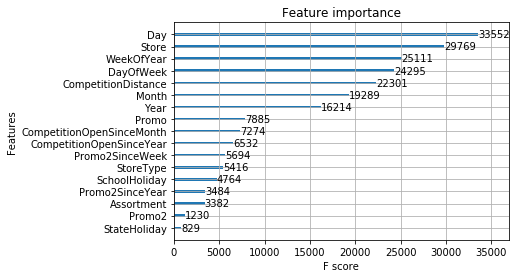

In [23]:
yhat = model_final.predict(xgb.DMatrix(X_test[independents]))
error = rmspe(X_test.Sales.values, np.exp(yhat))

print('First validation yelds RMSPE: {:.6f}'.format(error))

xgb.plot_importance(model_final)

In [42]:
unseen = xgb.DMatrix(test_store[independents])
test_p = model_final.predict(unseen)

forecasts = pd.DataFrame({'Id': test['Id'], 
                          'Sales': np.exp(test_p)})
# forecasts
forecasts.head()

,Id,Sales
Date,,
2015-09-17,1,4235.434082
2015-09-17,2,4387.080566
2015-09-17,3,4942.727051
2015-09-17,4,5196.984375
2015-09-17,5,5427.250000
